## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('landing_page=="new_page" and group !="treatment"').shape[0]

1928

f. Missing values

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. We should remove these rows as we cant be confident in them and store our new dataframe in **df2**.

In [8]:
#We should remove these rows as we cant be confident in them
df2= df.query(('landing_page=="new_page" and group =="treatment" or landing_page=="old_page" and group =="control"' ))
df2['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

In [11]:
df3 = df2.copy()
df3['is_duplicated']= df3['user_id'].duplicated()
df3.query('is_duplicated == True')


,user_id,timestamp,group,landing_page,converted,is_duplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


b. **user_id** repeated in **df2**. 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Information for the repeat **user_id**

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep our dataframe as **df2**.

In [14]:
df2.drop(2893, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.`
a. The probability of an individual converting regardless of the page they receive.

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
convert_old = df2.query('group =="control"')['converted'].mean()
convert_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
convert_new = df2.query('group =="treatment"')['converted'].mean()
convert_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688



Considering the proportion of control and treatment groups is 50%. The probability that individual will convert is higher in the control group (old version) is  0.1204 and  0.1188 in experiment group. The company should consider keeping the old version, however, there are might be other underlying factors and the further tests might be conducted. 

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` I will make the decision just based on all the data provided. 




H0: **$p_{new}$** <= **$p_{old}$**


H1: **$p_{new}$** > **$p_{old}$**

`2.` Let's say under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**  <br><br>

and perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a.**convert rate** for $p_{new}$ under the null 

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

b.**convert rate** for $p_{old}$ under the null <br><br>


In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

c. $n_{new}$

In [21]:
n_new = df2.query('group =="treatment"')['converted'].shape[0]
n_new

145310

d.$n_{old}$

In [22]:
n_old = df2.query('group =="control"')['converted'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
p_null = p_old
new_page_converted = np.random.binomial(1,p_null, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_null, n_new)

g.$p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [25]:
obs_diff = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
obs_diff

-0.0015782389853555567

h. Simulation of 10,000 $p_{new}$ - $p_{old}$ values to store all 10,000 values in **p_diffs**.

In [26]:
# p_diffs = []
# size= df2.shape[0]
# for _ in range(10000):
#     b_samp = df2.sample(size, replace=True)
#     control_df = b_samp.query('group == "control"')
#     treatment_df = b_samp.query('group == "treatment"')
#     exp_diff = treatment_df['converted'].mean()-control_df['converted'].mean()
#     p_diffs.append(exp_diff)
p_diffs = np.random.binomial(n_new, p_null, 10000)/n_new - np.random.binomial(n_old, p_null, 10000)/n_old

i. Plot a histogram of the **p_diffs**. 

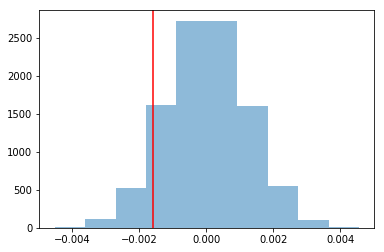

In [27]:
plt.hist(p_diffs, alpha = 0.5);
# plot line for observed statistic
plt.axvline(x= obs_diff, color = 'r');

In [28]:
(p_diffs>obs_diff).mean()

0.9073



In part j I tried to determine if the result is not due to the chance and it has a significant difference by computing the p-value. It looks like the statistic comes from null distribution. The p-value of 0.9 is more than alpha. The result is not significant and the company should reject the alternative hypothesis. The new page has no better conversion rate compare to the old page and company should keep the old page. 

l. I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code.

In [29]:
import statsmodels.api as sm

convert_old  = df2.query('group =="control"')['converted'].sum()
convert_new  = df2.query('group =="treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m.`stats.proportions_ztest` to compute test statistic and p-value.  

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
z_score, p_value

(-1.3109241984234394, 0.18988337448195103)

In [31]:
from scipy.stats import norm

print(norm.cdf(z_score)) # Tells us how significant our z-score is

print(norm.ppf(1-(0.05/2))) # Tells us what our critical value at 95% confidence is


0.094941687241
1.95996398454



Since the z-score exceeds the critical value of -1.959963984540054, we reject the alternative hypothesis  

Landing page new (17264/145311) is statistically not different or better than landing page old (17489/145274).

Despite the result is slightly different in part I and part II, they agree in between towards null hypothesis. The p-value of 0.9 in part I and p-value of .19 more than alpha. We would expect their long-term performance to be no different from one another.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will see that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>


**Logistic regression**


b. The goal, now,  is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first I need to create a colun for the intercept, and create a dummy variable column for which page each user received. 

In [32]:
import statsmodels.api as sm;

ab_page = pd.get_dummies(df2['group'])
df_new = df2.join(ab_page)
df_new['intercept'] = 1
df_new.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. I use **statsmodels** to import our regression model.  

In [33]:
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'treatment']])
results = lm.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d.The summary of our model below.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:54:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


In regression models, the slope and the intercept are equal to 0 in the null hypothesis. The alternative hypothesis by default is a computation of p-value to determine if p is equal or not equal to 0.  We can interpret this as saying that under the null hypothesis there is no trend and the best estimate/predictor of a new observation is the mean which is 0 in the case of no intercept. To compare regression results with the result in Part II, both outcomes tend towards the null hypothesis and the treatment group doesn't have a significant influence on the result.



Other things that might have an effect are novelty affect and change aversion. However, if we talk about other factors we might test in the regression model could include, seasonal trends and geographical location of the users. The disadvantages of adding the new factors lay in a core or regression model as we want to make sure that parameters have correlation on the result but not between each other. 


g. Now along with testing if the conversion rate changes for different pages, I also add an effect based on which country a user lives. 

In [35]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df_new1 = df_new.merge(df_countries, on = 'user_id')
df_new1.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [37]:
country_page = pd.get_dummies(df_new1['country'])
df_new1 = df_new1.join(country_page)
df_new1.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [38]:
lm = sm.Logit(df_new1['converted'], df_new1[['intercept', 'treatment','UK','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 27 Sep 2019   Pseudo R-squ.:               2.323e-05
Time:                        02:54:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [39]:
df_new1['CA_new_page'] = df_new1['treatment']*df_new1['CA']
df_new1['US_new_page'] = df_new1['treatment']*df_new1['US']
df_new1['UK_new_page'] = df_new1['treatment']*df_new1['UK']
df_new1['CA_old_page'] = df_new1['control']*df_new1['CA']
df_new1['US_old_page'] = df_new1['control']*df_new1['US']
df_new1['UK_old_page'] = df_new1['control']*df_new1['UK']
df_new1.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept,country,CA,UK,US,CA_new_page,US_new_page,UK_new_page,CA_old_page,US_old_page,UK_old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1,0,0,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1,0,0,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1,0,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1,0,1,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1,0,0,0,0,1,0


In [40]:
lm = sm.Logit(df_new1['converted'], df_new1[['intercept', 'treatment','CA_new_page','US_new_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 27 Sep 2019   Pseudo R-squ.:               3.351e-05
Time:                        02:54:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment       0.0074      0.018      0.410      0.682      -0.028       0.043
CA_new_page    -0.0901      0.040     -2.225      0.026      -0.169      -0.011
US_new_page    -0.0257      0.019     -1.363      0.173      -0.063       0.011
===============================================================================
"""

From the section g,  it can be observed that the slopes of variables are different, in simple words it identifies that different countries convert differently, to test if there is a relationship between countries and old or new pages on the covertions rate we can multiply these variables and add to our model. Interpreting the results,  we can see that none of the countries has statistical significance on result regardless of, new or old page users visited. Still, the country with the smallest p-value has the highest influence. This country is Canada with the new landing page. 